In [5]:
from google.colab import drive

# Unmount Google Drive
drive.flush_and_unmount()

# Mount Google Drive
drive.mount('/content/drive')


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [8]:
import os
import shutil
from PIL import Image, ImageOps
import matplotlib.pyplot as plt


In [9]:
source_dir = '/content/drive/My Drive/organized_data'
print("Contents of the organized data:")
print(os.listdir(source_dir))

Contents of the organized data:
['spoof', 'live']


In [11]:
# Splicing a list is not efficient when working with such a large dataset. I will write my own head function for early stopping.

def head(filepath):
  head = []
  for _, _, files in os.walk(filepath):
    for file in files:
      if len(head) < 5:
        head.append(file)
  return head

In [19]:
spoof_path = source_dir + '/spoof'
print(spoof_path)
print("Head of the spoof data:")
print(head(spoof_path))

/content/drive/My Drive/organized_data/spoof
Head of the spoof data:
['555695.png', '551368.png', '533395.png', '533407.png', '548829.png']


In [13]:
live_path = source_dir + '/live'
print(live_path)
print("Head of the live data:")
print(head(live_path))

/content/drive/My Drive/organized_data/live
Head of the live data:
['526487.png', '500674.png', '528930.png', '524172.png', '523216.png']


In [15]:
def preprocess_image(image_path, output_size, save=False, save_path=None):
    with Image.open(image_path) as img:
        # Pad the image to a square, evenly
        max_side = max(img.size)
        left = (max_side - img.size[0]) // 2
        top = (max_side - img.size[1]) // 2
        right = max_side - img.size[0] - left
        bottom = max_side - img.size[1] - top
        img = img.crop((-left, -top, img.size[0] + right, img.size[1] + bottom))

        # Scale the image to the output size
        img = img.resize(output_size, Image.LANCZOS)

        # Optionally, save the image
        if save:
            img.save(save_path)

        return img


In [16]:
def display_original_and_preprocessed(original_path, output_size):
    processed_img = preprocess_image(original_path, output_size)

    original_img = Image.open(original_path)

    _, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_img)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(processed_img)
    axs[1].set_title('Preprocessed Image')
    axs[1].axis('off')

    plt.show()

In [17]:
output_size = (224, 224)

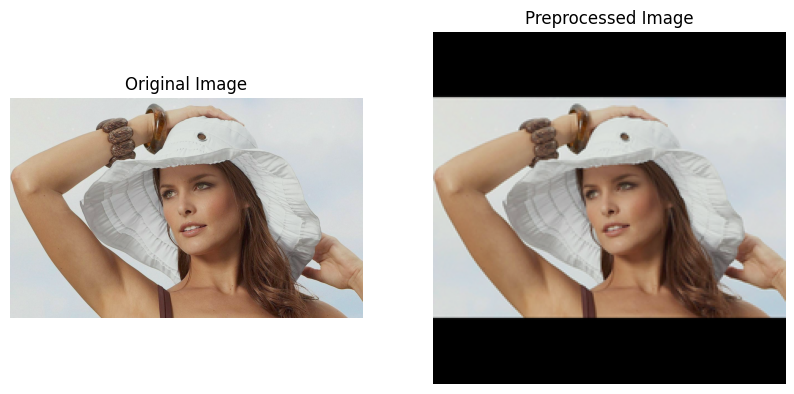

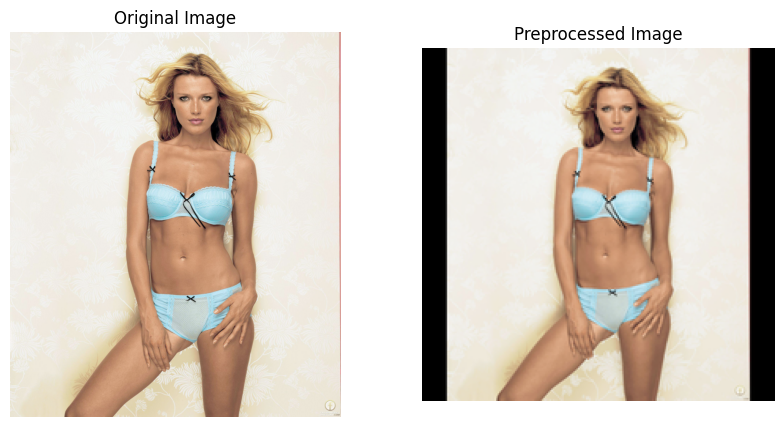

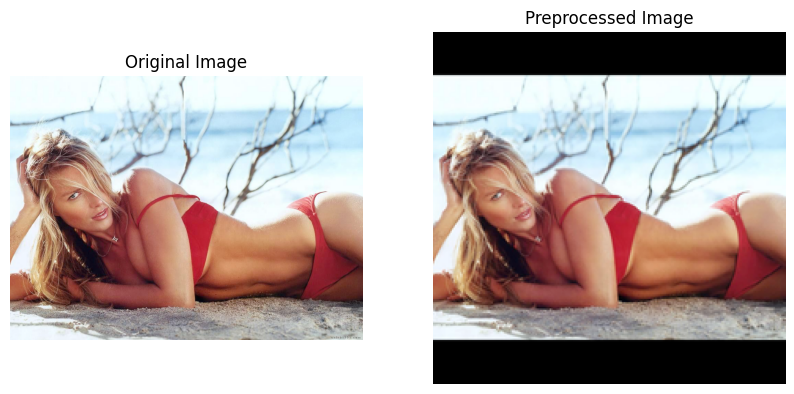

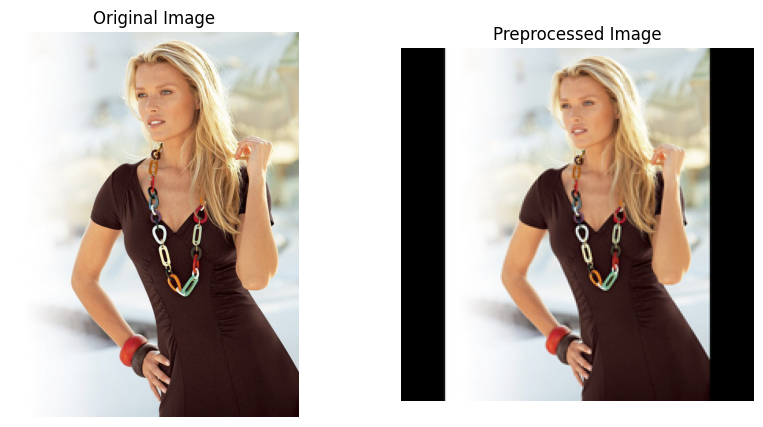

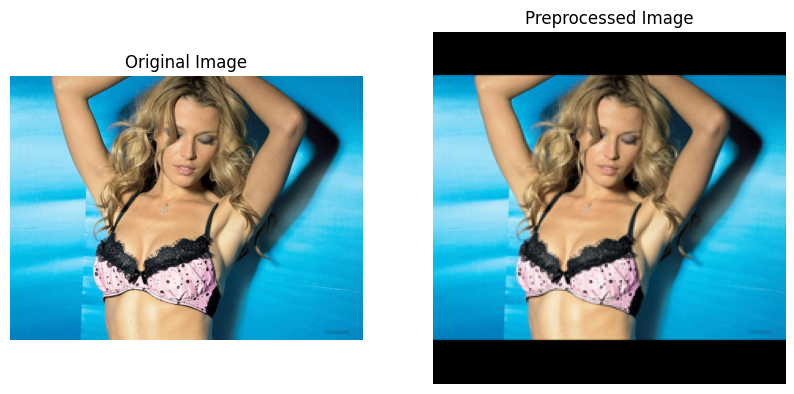

In [45]:
# Testing the preprocessing function on LIVE images
for image in head(live_path):
  path = os.path.join(live_path, image)
  display_original_and_preprocessed(path, output_size)

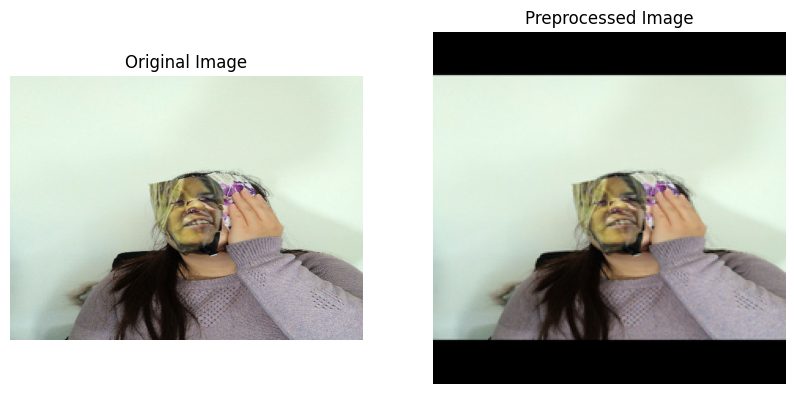

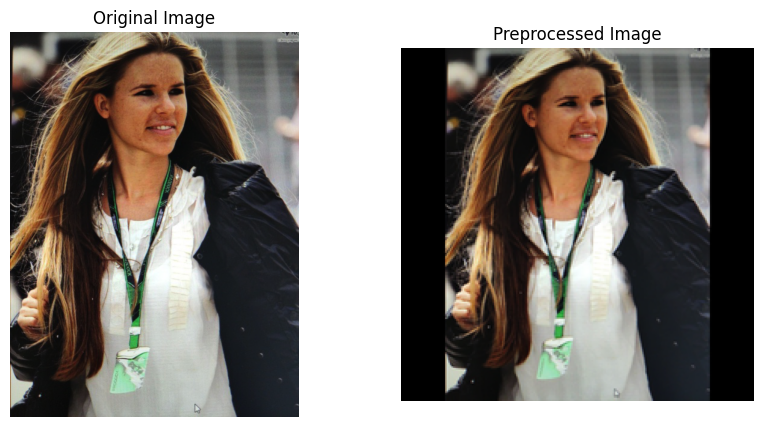

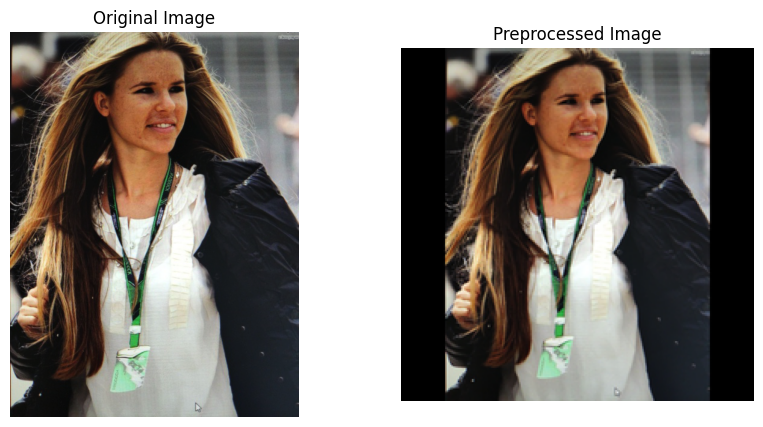

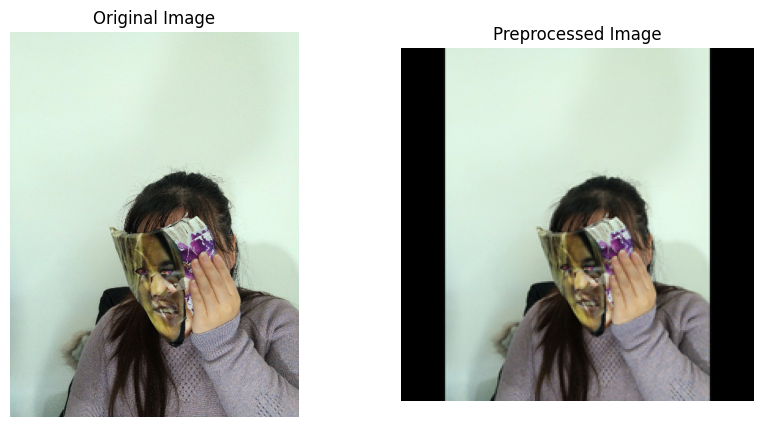

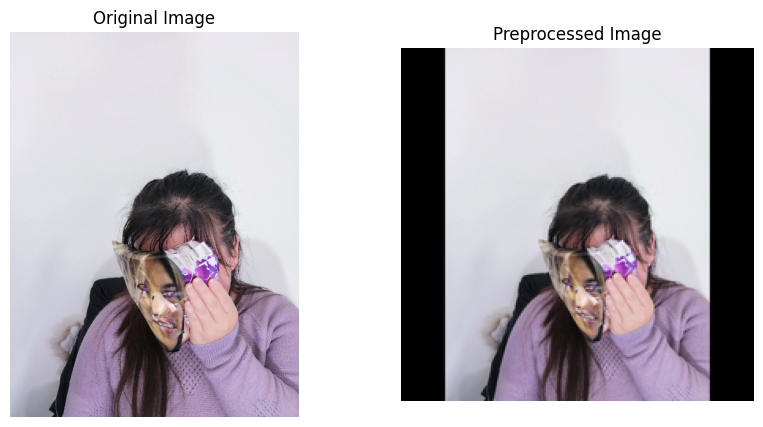

In [46]:
# Testing the preprocessing function on SPOOF images
for image in head(spoof_path):
  path = os.path.join(spoof_path, image)
  display_original_and_preprocessed(path, output_size)

In [18]:
preprocessed_data_dir = '/content/drive/My Drive/preprocessed_data'

In [7]:
# Apply preprocessing to all images; save the results to a new directory
# Basic version that works

# Set the source and destination directories
source_dir = '/content/drive/My Drive/organized_data'
preprocessed_data_dir = '/content/drive/My Drive/preprocessed_data'
output_size = (224, 224)

def preprocess_all(source_dir, preprocessed_data_dir, output_size):
    for subtype in ['live', 'spoof']:
        curr_path = os.path.join(source_dir, subtype)
        preprocessed_path = os.path.join(preprocessed_data_dir, subtype)

        if not os.path.exists(preprocessed_path):
            os.makedirs(preprocessed_path)

        if os.path.exists(curr_path):
            for file_name in os.listdir(curr_path):
                full_file_path = os.path.join(curr_path, file_name)
                save_path = os.path.join(preprocessed_path, file_name)

                # Skip files that have already been processed
                if not os.path.isfile(save_path):
                    if os.path.isfile(full_file_path):
                        preprocess_image(full_file_path, output_size, save=True, save_path=save_path)
        else:
            print(f"Directory does not exist: {curr_path}")
        print("Preprocessing complete. ")

In [4]:
preprocess_all(source_dir, preprocessed_data_dir, output_size)

NameError: name 'os' is not defined

In [ ]:
# The above works, but it takes a long time because we do images one-by-one
# I will attempt parallel processing to speed this up.
# The below is not necessary to perform.
# Using 8 max

In [6]:
def process_image_task(image_info):
    image_path, output_size, save_path = image_info
    try:
        # Call the preprocess function
        preprocess_image(image_path, output_size, save=True, save_path=save_path)
        return f"Processed {image_path}"
    except Exception as e:
        return f"Error processing {image_path}: {str(e)}"


In [22]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def preprocess_all_in_parallel(source_dir, preprocessed_data_dir, output_size, max_workers=4):
    for subtype in ['live', 'spoof']:
        curr_path = os.path.join(source_dir, subtype)
        preprocessed_path = os.path.join(preprocessed_data_dir, subtype)

        if not os.path.exists(preprocessed_path):
            os.makedirs(preprocessed_path)

        if os.path.exists(curr_path):
            # Prepare a list of tasks
            tasks = []
            for file_name in os.listdir(curr_path):
                full_file_path = os.path.join(curr_path, file_name)
                save_path = os.path.join(preprocessed_path, file_name)
                # Check if the processed file already exists before adding it to the task list
                if os.path.isfile(full_file_path) and not os.path.exists(save_path):
                    tasks.append((full_file_path, output_size, save_path))

            # Process the tasks in parallel
            with ThreadPoolExecutor(max_workers=max_workers) as executor:
                future_to_image = {executor.submit(process_image_task, task): task for task in tasks}
                for future in as_completed(future_to_image):
                    image_info = future_to_image[future]
                    try:
                        print(future.result())
                    except Exception as exc:
                        print(f'%r generated an exception: %s' % (image_info, exc))
        else:
            print(f"Directory does not exist: {curr_path}")
        print("Preprocessing complete. ")


In [ ]:
preprocess_all_in_parallel(source_dir, preprocessed_data_dir, output_size, max_workers=8)